In [1]:
using DelaySSAToolkit, Catalyst
using Test,BenchmarkTools

This model is modified from DiffEqProblemLibrary.jl 

In [2]:
function getdelayDiffNetwork(N)
    diffnetwork = make_empty_network()
    @parameters t K
    @variables X[1:N](t), Y[1:N](t)
    for i = 1:N
        addspecies!(diffnetwork, X[i])
    end
    for i = 1:N
        addspecies!(diffnetwork, Y[i])
    end
    addparam!(diffnetwork, K)
    for i in 1:(N-1)
        addreaction!(diffnetwork, Reaction(K, [X[i]], [X[i+1], Y[i]]))
        addreaction!(diffnetwork, Reaction(K, [X[i+1]], [X[i], Y[i+1]]))
    end
    diffnetwork
end
tf = 10.
N = 64
u0 = zeros(Int64,2*N)
u0[1:10:N] .= 3
rn = getdelayDiffNetwork(N);

In [3]:
params = [500]
de_chan0 = (a = []; for i in 1:N push!(a, []) end; a)
τ = 0.01
trigger_reactions = []
complete_reactions = []
k = 1
for i in 1:N-1
    push!(trigger_reactions, k=>[i=>τ])
    push!(trigger_reactions, k+1=>[i+1=>τ])
    k += 2
end
trigger_reactions
complete_reactions = [i=>[N+i=>-1] for i in 1:N];

In [4]:
delay_trigger = Dict(trigger_reactions)
delay_complete = Dict(complete_reactions)
# delay_complete
delay_interrupt = Dict()
delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)

jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws = false)
dprob    = DiscreteProblem(jumpsys, u0, (0.0, tf), params);

In [10]:
medianlist=[]
algo_list =[DelayDirect(),DelayRejection(),DelayMNRM(),DelayDirectCR()]
for algo in algo_list
    djprob = DelayJumpProblem(jumpsys,dprob,algo,delayjumpset, de_chan0, save_positions=(false,false))
    bm = @benchmark solve($djprob, SSAStepper())
    push!(medianlist,copy(median(bm).time/1e9))
end;

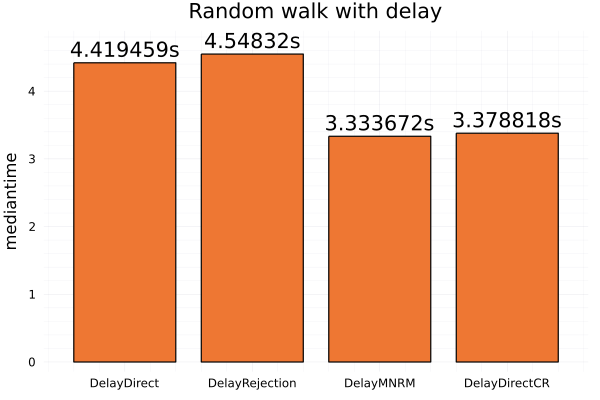

In [2]:
using Plots; theme(:vibrant)
medianvalue=[string(round(mt,digits=6),"s") for mt in medianlist]
algo_name = ["DelayDirect","DelayRejection","DelayMNRM","DelayDirectCR"]
bar(algo_name,medianlist,legend=:false,title="Random walk with delay",ylabel="mediantime")
scatter!(algo_name, 0.2 .+ medianlist , markeralpha=0, series_annotations=medianvalue)